In [1]:
from transforms import Deslant
from torchvision.transforms import Compose
from dataset import CTCData
import cv2
import matplotlib.pyplot as plt

In [2]:
def show_img(img):
    cv2.imshow('', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def plot_img(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def bounding_box(x1,y1,x2,y2,img):
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img

In [3]:
import pandas as pd
import os
df = pd.read_csv('../../Dataset/DIDA/DIDA_Label1.csv').astype(str)
word_df=df
chars = []
word_col=-1
word_df.iloc[:, word_col].apply(lambda x: chars.extend(list(x)))
# 
# chars = sorted(list(set(chars)))
# char_dict = {c:i for i, c in enumerate(chars, 1)}

0       None
1       None
2       None
3       None
4       None
        ... 
1855    None
1856    None
1857    None
1858    None
1859    None
Name: word, Length: 1860, dtype: object

In [4]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [5]:
path="../../Dataset/DIDA/DIDA_1/"
path2="../../Dataset/DIDA/DIDA_2/"

for filename in os.listdir(path):
    full_path=os.path.join(path,filename)
    img=cv2.imread(full_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh=thresholding(gray)
    cv2.imwrite(path2+filename,thresh)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../Dataset/DIDA/DIDA_1/'

In [6]:
dataset = CTCData(csv_file='DIDA_Label1.csv', 
                  root_dir='../../Dataset/DIDA/DIDA_2/',
                  transform=Compose([
                     Deslant()]))

In [7]:
dataset[102]

{'image': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 'word': '1830'}

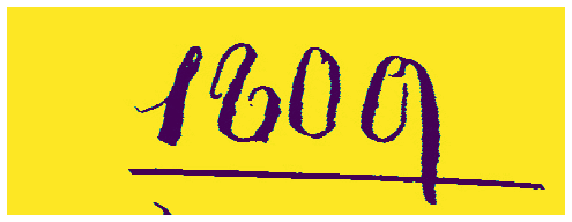

In [8]:
import matplotlib.pyplot as plt
plot_img(dataset[20]['image'])

In [9]:
dataset.word_df.file.iloc[100]

'10241.jpg'

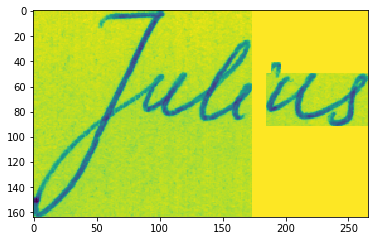

In [13]:
from skimage import io
import os
root_dir='/home/jupyter/tutorials/my_projects/word_recognition/words'
im = io.imread(os.path.join(root_dir, dataset.get_folder(dataset.word_df.file.iloc[810]), dataset.word_df.file.iloc[810]))
plt.imshow(im)

In [14]:
from dataset import CTCData
from dataloader import CTCDataLoader
from transforms import Rescale, Deslant, toRGB, ToTensor, Normalise
from torchvision.transforms import Compose
import torch

# use gpu if available
dev = "cuda" if torch.cuda.is_available() else "cpu"
dev="cpu"
# create the CTCDataset
dataset = CTCData(csv_file='DIDA_Label1.csv',                                               # csv name
        root_dir='../../Dataset/DIDA/DIDA_2/',  # root directory of csv and images
                  transform=Compose([                                                     # compose sequence of transforms
                   # Deslant(),                                                           # Deslant whole dataset before.
                     Rescale(output_size=(64, 800),                                       # one key part is that the image
                            random_pad=True,                                              # is rotated 90 degrees (w, h)
                            border_pad=(4, 10), 
                            random_rotation=2,                                            # random angle rotation (+/-)
                            random_stretch=1.2),                                          # randomly stretch the line (up to)
                     toRGB(),                                                            # converted to RGB - imagenet 
                     ToTensor(rgb=True),                                                 # was 3 channel images
                      Normalise(mean=[0.485, 0.456, 0.406],                              # pretrained resnet
                                  std=[0.229, 0.224, 0.225])]))                          # must use imagenet stats!

# Create a dataloader
dl = CTCDataLoader(dataset,                                                              # pass the dataset
                   batch_size=(120,240),                                                 # train batchsize, val batchsize
                   validation_split=0.2,                                                 # size of validation split [0-1]
                   shuffle=True,                                                         # shuffle the dataset
                   seed=42,                                                              # random seed - for reproducibility
                   device=dev)                                                           # on CPU or GPU?

In [15]:
from model import CTCModel
model = CTCModel(chan_in=3,                                                             # 3 channel image - imagenet pretrained
                 time_step=96,                                                          # this is the max length possible                                                  
                 feature_size=512,                                                      # conv outputs 512, 32, 1
                 hidden_size=512,                        
                output_size=len(dataset.char_dict) + 1,                                 # output matrix has to have col for each letter
                 num_rnn_layers=4,                                                      # plus 1 for special blank character 
                 rnn_dropout=0)
model.load_pretrained_resnet()                                                          # load some pretrained weights
model.to(dev)                                                                           # put the model parameters on CPU/GPU

CTCModel(
  (cnn): CNN(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
    (relu): ReLU(inplace=True)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [16]:
from learn import Learner
learn = Learner(model=model,                                                           
                dataloader=dl,                                                         
               decode_map={v:k for k,v in dataset.char_dict.items()})                  # inverse of char_dict
learn.freeze()                                                                         # freeze the conv weights
log, lr = learn.find_lr(start_lr=1e-5, end_lr=1e1, wd=0.1)                             # find a suitable learning rate
                                                                                       # wd = weight decay
# based on https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

KeyboardInterrupt: 

In [ ]:
# first run - frozen - just a demo - want to do more epochs if actual training
print('Training with ResNet parameters frozen')
learn.fit_one_cycle(epochs=1, max_lr=1e-3, base_lr=1e-4, wd=0.1)

# unfreeze all weights
print('Training with all parameters (CNN + LSTM) unfrozen')
learn.unfreeze()
learn.fit_one_cycle(epochs=1, max_lr=1e-3, base_lr=1e-4, wd=0.1)

Training with ResNet parameters frozen


RuntimeError: CUDA out of memory. Tried to allocate 364.00 MiB (GPU 0; 4.00 GiB total capacity; 1.87 GiB already allocated; 69.70 MiB free; 2.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF